In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mticker

## The Advanced Computing Center for Research and Education

**Project Overview**
The Advanced Computing Center for Research and Education (ACCRE) operates Vanderbilt University's high-performance computing cluster. Jobs submitted to ACCRE are managed by the [slurm scheduler](https://slurm.schedmd.com/documentation.html), which tracks compute and memory resources.

**ACCRE staff have hypothesized that the scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.**

My goal is to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.

My provided datasets are:  
* fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".  
* slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).  
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:  
    * return code = 1
    * execution time > 15 seconds

## **Phase 1: Explore the Data**  
Objectives:  
* Understand the purpose of each dataset.  
* Inspect column types, sizes, and example rows.  

Notebook Sections:  
* Code: Load each dataset, preview rows, summarize columns.  
* Markdown: Notes on data quality and initial observations.  

In [2]:
jobs = pd.read_csv('../data/fullsample.csv')
jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31T23:39:00,2020-10-31T23:40:46,2000Mn,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31T23:39:13,2020-10-31T23:40:38,2000Mn,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31T23:46:29,2020-10-31T23:49:43,4096Mc,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31T23:49:44,2020-10-31T23:51:40,2000Mn,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


The data has 12 columns with objects and int64s. This dataframe is a list of jobs that were submitted. 

### First step is to clean up the data from the .log files. This needs to be completed before manipulating and investigating the data. 

In [3]:
ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

#clean and rename columns
ce5.columns = ['Date and Time', 'User', 'Retry', 'Run_Time', 'Return_Code', 'Command']

In [4]:
#created a list of unwanted words
unwanted_words = ['user', 'retry', 'time', 'returncode', 'command']

#removed the unwanted words
for word in unwanted_words:
    ce5['User'] = ce5['User'].str.replace(word, '', regex=False).str.strip()
    ce5['Retry'] = ce5['Retry'].str.replace(word, '', regex=False).str.strip()
    ce5['Run_Time'] = ce5['Run_Time'].str.replace(word, '', regex=False).str.strip()
    ce5['Return_Code'] = ce5['Return_Code'].str.replace(word, '', regex=False).str.strip()
    ce5['Command'] = ce5['Command'].str.replace(word, '', regex=False).str.strip()
    

ce5.head()

,Date and Time,User,Retry,Run_Time,Return_Code,Command
0,2020-10-16 08:15:39.278699,0,0,0.07347559928894043,0,"['/usr/bin/sacct', '-u', 'appelte1', '-S', '20..."
1,2020-10-16 08:18:08.313309,0,0,0.18363237380981445,0,"['/usr/bin/sacct', '-u', 'appelte1', '-S', '20..."
2,2020-10-16 08:22:48.128689,0,0,0.07547116279602051,0,"['/usr/bin/sacct', '-u', 'appelte1', '-S', '20..."
3,2020-10-16 08:25:13.257408,0,0,0.09484362602233887,0,"['/usr/bin/sacct', '-u', 'appelte1', '-S', '20..."
4,2020-10-16 08:31:01.460723,0,0,0.07498788833618164,0,"['/usr/bin/sacct', '-u', 'appelte1', '-S', '20..."


In [5]:
ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                  header=None,
                  delimiter=' - ',
                  engine='python')

In [6]:
#rename columns and clean columns 
ce6.columns = ['Date and Time', 'User', 'Retry', 'Run_Time', 'Return_Code', 'Command']

#removed the unwanted words
for word in unwanted_words:
    ce6['User'] = ce6['User'].str.replace(word, '', regex=False).str.strip()
    ce6['Retry'] = ce6['Retry'].str.replace(word, '', regex=False).str.strip()
    ce6['Run_Time'] = ce6['Run_Time'].str.replace(word, '', regex=False).str.strip()
    ce6['Return_Code'] = ce6['Return_Code'].str.replace(word, '', regex=False).str.strip()
    ce6['Command'] = ce6['Command'].str.replace(word, '', regex=False).str.strip()

ce6.head()

,Date and Time,User,Retry,Run_Time,Return_Code,Command
0,2020-10-16 10:37:44.163454,9202,0,0.08495402336120605,0,"['/usr/bin/scontrol', 'show', 'job', '24997187']"
1,2020-10-16 10:37:44.206654,9202,0,0.08943057060241699,0,"['/usr/bin/scontrol', 'show', 'job', '24997190']"
2,2020-10-16 10:37:44.218760,9202,0,0.05928945541381836,0,"['/usr/bin/scontrol', 'show', 'job', '24997193']"
3,2020-10-16 10:37:44.256403,9202,0,0.038695573806762695,0,"['/usr/bin/scontrol', 'show', 'job', '24997189']"
4,2020-10-16 10:37:44.611603,9202,0,0.03343677520751953,0,"['/usr/bin/scontrol', 'show', 'job', '24997192']"


## **Phase 2: Clean and Transform the Data**  
Objectives:  
* Extract job completions from fullsample.csv.  
* Parse CE5 and CE6 logs to identify unresponsive events.  
* Create analysis-ready features (time windows, completion counts, unresponsiveness indicators).  
* Optionally include other features (currently running jobs or resource usage, time-of-day).  

Notebook Sections:  
* Code: Filtering and transforming datasets.  
* Markdown: Document preprocessing steps and reasoning.  
* Code: Combine datasets into a single dataset suitable for analysis.

### Next, I wanted to organize all of the jobs that based on 4 categories:
- Responsive and Unresponsive periods
- Response code was 1 
- Made by the user 9204
- An execution time is greater than 15 seconds

### Then I merged them to included if they were responsive or not into one dataframe.


In [7]:
ce6_responsive = ce6[(ce6['User'] == '9204') & (ce6['Return_Code'] == '0') & (pd.to_numeric(ce6['Run_Time']) <= 15) & (ce6['Command'].str.contains('/usr/bin/sbatch'))]

In [8]:
ce6_unresponsive = ce6[(ce6['User'] == '9204') & (ce6['Return_Code'] != '0') & (pd.to_numeric(ce6['Run_Time']) > 15) & (ce6['Command'].str.contains('/usr/bin/sbatch'))]

In [9]:
ce5_responsive = ce5[(ce5['User'] == '9204') & (ce5['Return_Code'] == '0') & (pd.to_numeric(ce5['Run_Time']) <= 15) & (ce5['Command'].str.contains('/usr/bin/sbatch'))]

In [10]:
ce5_unresponsive = ce5[(ce5['User'] == '9204') & (ce5['Return_Code'] != '0') & (pd.to_numeric(ce5['Run_Time']) > 15) & (ce5['Command'].str.contains('/usr/bin/sbatch'))]

In [11]:
concat_unresponsive_logs = pd.concat([ce6_unresponsive, ce5_unresponsive]) 
concat_unresponsive_logs.head()

,Date and Time,User,Retry,Run_Time,Return_Code,Command
36913,2020-10-18 06:16:25.392946,9204,0,20.03767156600952,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
37605,2020-10-18 06:38:44.172473,9204,0,20.03873610496521,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
39075,2020-10-18 07:47:32.241050,9204,0,20.01834774017334,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
39356,2020-10-18 08:08:49.366063,9204,0,20.030496835708618,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
40072,2020-10-18 08:57:22.419398,9204,0,20.038508415222168,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."


In [12]:
concat_unresponsive_logs['Response'] = 0

In [13]:
concat_responsive_logs = pd.concat([ce6_responsive, ce5_responsive]) 
concat_responsive_logs.head()

,Date and Time,User,Retry,Run_Time,Return_Code,Command
13,2020-10-16 10:38:29.869156,9204,0,0.06946611404418945,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
307,2020-10-16 11:08:28.127242,9204,0,2.43306303024292,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
770,2020-10-16 11:38:39.372164,9204,0,3.0388524532318115,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
1026,2020-10-16 11:48:53.966179,9204,0,0.2433319091796875,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."
1238,2020-10-16 12:03:45.852682,9204,0,0.4414970874786377,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5..."


In [14]:
concat_responsive_logs['Response'] = 1

In [15]:
concat_logs = pd.concat([concat_responsive_logs, concat_unresponsive_logs])
concat_logs['Date and Time'] = pd.to_datetime(concat_logs['Date and Time'])
concat_logs

,Date and Time,User,Retry,Run_Time,Return_Code,Command,Response
13,2020-10-16 10:38:29.869156,9204,0,0.06946611404418945,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",1
307,2020-10-16 11:08:28.127242,9204,0,2.43306303024292,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",1
770,2020-10-16 11:38:39.372164,9204,0,3.0388524532318115,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",1
1026,2020-10-16 11:48:53.966179,9204,0,0.2433319091796875,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",1
1238,2020-10-16 12:03:45.852682,9204,0,0.4414970874786377,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",1
...,...,...,...,...,...,...,...
4657074,2021-09-24 13:13:11.616619,9204,0,20.03128671646118,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",0
4661025,2021-09-24 18:14:35.862916,9204,0,20.041435956954956,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",0
4661384,2021-09-24 19:13:14.894282,9204,0,20.051321268081665,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",0
4726331,2021-10-02 08:14:16.557499,9204,0,19.083227396011353,1,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x5...",0


### Next, we selected only the jobs that were completed to look if the job was scheduled.  

In [16]:
complete_jobs = jobs.loc[jobs['STATE'] == 'COMPLETED']
complete_jobs['END'] = pd.to_datetime(complete_jobs['END'])
complete_jobs

/var/folders/h8/51mqc9v517x00_mhcb5s7ncw0000gn/T/ipykernel_42018/2859491880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_jobs['END'] = pd.to_datetime(complete_jobs['END'])


,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07 20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10 16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17T07:45:07,2021-09-06 16:17:34,16384Mn,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31T23:39:00,2020-10-31 23:40:46,2000Mn,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31T23:39:13,2020-10-31 23:40:38,2000Mn,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31T23:46:29,2020-10-31 23:49:43,4096Mc,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31T23:49:44,2020-10-31 23:51:40,2000Mn,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


### Then for the method of investigation to work, I needed to take the dataframes and combine them. So, I used the merge_asof to combine them into one dataframe without dropping any of the jobs.

In [17]:
left = concat_logs.sort_values('Date and Time')
right = complete_jobs.sort_values('END')

jobs_and_logs = pd.merge_asof(
    left, 
    right,
    left_on='Date and Time',
    right_on='END',
    allow_exact_matches=False
)

all_jobs_and_logs = pd.merge(jobs_and_logs[['JOBID', 'Response', 'Date and Time']], complete_jobs, how = 'outer')
all_jobs_and_logs = all_jobs_and_logs.drop_duplicates('JOBID')
all_jobs_and_logs

,JOBID,Response,Date and Time,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,24389519,NaN,NaT,COMPLETED,2020-10-05T22:59:14,2020-10-13 16:53:24,2048Mn,110.41M,8-22:31:00,7-17:54:10,1,1,production,0:0
1,24426209,NaN,NaT,COMPLETED,2020-10-03T15:21:49,2020-10-04 23:37:30,40960Mn,4208.86M,4-04:00:00,1-08:15:41,1,2,production,0:0
2,24429945,NaN,NaT,COMPLETED,2020-10-05T23:51:10,2020-10-07 22:30:18,8192Mn,4310.27M,6-06:00:00,1-22:39:08,1,1,production,0:0
3,24429970,NaN,NaT,COMPLETED,2020-10-05T23:58:20,2020-10-08 04:41:39,8192Mn,4310.93M,6-06:00:00,2-04:43:19,1,1,production,0:0
4,24435524_182,NaN,NaT,COMPLETED,2020-10-02T18:19:46,2020-10-03 09:12:44,2048Mn,695.13M,2-00:00:00,14:52:58,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380276,32923987,1.0,2021-10-07 20:14:58.603967,COMPLETED,2021-10-07T20:09:26,2021-10-07 20:11:21,2000Mn,0.09M,2-00:00:00,00:01:55,1,1,sam,0:0
7380277,32923988,1.0,2021-10-07 20:23:46.239798,COMPLETED,2021-10-07T20:15:05,2021-10-07 20:17:24,2000Mn,0.09M,2-00:00:00,00:02:19,1,1,sam,0:0
7380278,32923989,1.0,2021-10-07 20:30:32.230878,COMPLETED,2021-10-07T20:24:26,2021-10-07 20:26:01,2000Mn,393.07M,2-00:00:00,00:01:35,1,1,sam,0:0
7380279,32923996,1.0,2021-10-07 20:39:25.006097,COMPLETED,2021-10-07T20:31:08,2021-10-07 20:32:45,2000Mn,0.09M,2-00:00:00,00:01:37,1,1,sam,0:0


## Now that we have our data finalized, we can look at the numbers to discover what is happening.

## **Phase 3: Analyze and Visualize**  
Objectives:  
* Explore the relationship between job completions and unresponsiveness.  
* Create visualizations and basic summary statistics.  

Notebook Sections:  
* Code: Time-series plots, scatterplots, boxplots, summary statistics.
* Markdown: Interpret the visualizations and describe patterns.  
* Code: Fit a simple logistic regression to test the hypothesis.
* Markdown: Summarize the results and draw conclusions from the model.  
* Optional: Explore additional factors (eg. day of week).

### First, I want to look at the amount of completed jobs and what percent was completed.

In [18]:
percentage_completed = ((all_jobs_and_logs['Response'].dropna() == 1).mean()) * 100
print(f"{percentage_completed:.2f}% of jobs were completed.")
print(f"{((all_jobs_and_logs['Response'].dropna() == 1).count())} jobs we completed")

95.90% of jobs were completed.
55219 jobs we completed


### Now I wanted to see how many jobs were completed in the morning and afternoon. 

In [19]:
all_jobs_and_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7375084 entries, 0 to 7380280
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   JOBID          object        
 1   Response       float64       
 2   Date and Time  datetime64[ns]
 3   STATE          object        
 4   BEGIN          object        
 5   END            datetime64[ns]
 6   REQMEM         object        
 7   USEDMEM        object        
 8   REQTIME        object        
 9   USEDTIME       object        
 10  NODES          int64         
 11  CPUS           int64         
 12  PARTITION      object        
 13  EXITCODE       object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(9)
memory usage: 844.0+ MB


In [20]:
all_jobs_and_logs['Hour'] = all_jobs_and_logs['Date and Time'].dt.hour

# Create the Time_of_Day column 
all_jobs_and_logs['Time_of_Day'] = all_jobs_and_logs['Hour'].apply(
    lambda h: 'Morning' if h < 12 else 'Afternoon'
)

In [21]:
time_of_day_counts = all_jobs_and_logs['Time_of_Day'].value_counts()
time_of_day_counts

Time_of_Day
Afternoon    7347960
Morning        27124
Name: count, dtype: int64

In [22]:
all_jobs_and_logs.head(5)

,JOBID,Response,Date and Time,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,Hour,Time_of_Day
0,24389519,NaN,NaT,COMPLETED,2020-10-05T22:59:14,2020-10-13 16:53:24,2048Mn,110.41M,8-22:31:00,7-17:54:10,1,1,production,0:0,NaN,Afternoon
1,24426209,NaN,NaT,COMPLETED,2020-10-03T15:21:49,2020-10-04 23:37:30,40960Mn,4208.86M,4-04:00:00,1-08:15:41,1,2,production,0:0,NaN,Afternoon
2,24429945,NaN,NaT,COMPLETED,2020-10-05T23:51:10,2020-10-07 22:30:18,8192Mn,4310.27M,6-06:00:00,1-22:39:08,1,1,production,0:0,NaN,Afternoon
3,24429970,NaN,NaT,COMPLETED,2020-10-05T23:58:20,2020-10-08 04:41:39,8192Mn,4310.93M,6-06:00:00,2-04:43:19,1,1,production,0:0,NaN,Afternoon
4,24435524_182,NaN,NaT,COMPLETED,2020-10-02T18:19:46,2020-10-03 09:12:44,2048Mn,695.13M,2-00:00:00,14:52:58,1,1,production,0:0,NaN,Afternoon


In [23]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [24]:
jobs_complete_time_of_day = smf.logit('Response ~ Time_of_Day',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.169987
         Iterations 7


In [25]:
jobs_complete_time_of_day.params

Intercept                 2.940512
Time_of_Day[T.Morning]    0.485740
dtype: float64

### Here I am seeing if jobs were completed in the morning more often than in the afternoon.

In [26]:
Morning = 1

logit_p = jobs_complete_time_of_day.params['Intercept'] + jobs_complete_time_of_day.params['Time_of_Day[T.Morning]']*Morning

print(f'If there was a job submitted in the morning, then there was a {logistic(logit_p)*100:.2f}% chance of the scheduler completing the job.')

If there was a job submitted in the morning, then there was a 96.85% chance of the scheduler completing the job.


In [27]:
Morning = 0

logit_p = jobs_complete_time_of_day.params['Intercept'] + jobs_complete_time_of_day.params['Time_of_Day[T.Morning]']*Morning

print(f'If there was a job submitted in the afternoon, then there was a {logistic(logit_p)*100:.2f}% chance of the scheduler completing the job.')

If there was a job submitted in the afternoon, then there was a 94.98% chance of the scheduler completing the job.


### It looks like morning jobs were more likely to be completed. Now I will see how many jobs were submitted in the morning and afternoon.

In [28]:
all_jobs_and_logs['Time_of_Day'].value_counts()

Time_of_Day
Afternoon    7347960
Morning        27124
Name: count, dtype: int64

### Afternoon jobs were more less likely to be scheduled because there were a substantially large amount in the afternoon. This does not prove the original hypothesis, but it is likely where it originated from. 

## Next, I will fit a logistic regression model to test the hypothesis using different **Job amounts** and **Time Increments**.

## 1 Minute Increments

In [29]:
all_jobs_and_logs = all_jobs_and_logs.sort_values('END')

In [30]:
all_jobs_and_logs['rolling_1min'] = all_jobs_and_logs.rolling(window = '1min', on='END')['JOBID'].count()

In [31]:
jobs_complete_1min = smf.logit('Response ~ rolling_1min',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.171017
         Iterations 7


In [32]:
jobs_complete_1min.params

Intercept       3.114555
rolling_1min    0.002652
dtype: float64

In [33]:
q3_1min = all_jobs_and_logs['rolling_1min'].quantile(0.75)
p90_1min = all_jobs_and_logs['rolling_1min'].quantile(0.90)
median_1min = all_jobs_and_logs['rolling_1min'].quantile(0.50)

print(f'{median_1min} jobs were completed at the median.')
print(f'{q3_1min} jobs were completed at the 3rd quartile.')
print(f'{p90_1min} jobs were compeleted at the 90th percentile.')


32.0 jobs were completed at the median.
102.0 jobs were completed at the 3rd quartile.
200.0 jobs were compeleted at the 90th percentile.


In [34]:
jobs = 32

logit_p_1 = jobs_complete_1min.params['Intercept'] + jobs_complete_1min.params['rolling_1min']*jobs

print(f'If there was 32 job completions every 1 minute, then there was a {logistic(logit_p_1)*100:.2f}% chance of the scheduler schedules the job.')

If there was 32 job completions every 1 minute, then there was a 96.08% chance of the scheduler schedules the job.


In [35]:
jobs = 102

logit_p_1 = jobs_complete_1min.params['Intercept'] + jobs_complete_1min.params['rolling_1min']*jobs

print(f'If there was 102 job completions every 1 minute, then there was a {logistic(logit_p_1)*100:.2f}% chance of the scheduler schedules the job.')

If there was 102 job completions every 1 minute, then there was a 96.72% chance of the scheduler schedules the job.


In [36]:
jobs = 200

logit_p_1 = jobs_complete_1min.params['Intercept'] + jobs_complete_1min.params['rolling_1min']*jobs

print(f'If there was 200 job completions every 1 minute, then there was a {logistic(logit_p_1)*100:.2f}% chance of the scheduler schedules the job.')

If there was 200 job completions every 1 minute, then there was a 97.45% chance of the scheduler schedules the job.


#### Calculate the mean, 3rd quartile, and 90th percentile

In [37]:
jobs_complete_1min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                55219
Model:                          Logit   Df Residuals:                    55217
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:               0.0005444
Time:                        13:58:04   Log-Likelihood:                -9443.4
converged:                       True   LL-Null:                       -9448.5
Covariance Type:            nonrobust   LLR p-value:                  0.001339
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1146      0.025    127.047      0.000       3.067       3.163
rolling_1min     0.0027      0.001      3.000      0.003       0.001       0.004
================================================================================
"""

In the 1 minute time window, we see that it is statistically significant. However, it is such a small window to have an effect.

## 5 Minute Increments

In [38]:
all_jobs_and_logs['rolling_5min'] = all_jobs_and_logs.rolling(window = '5min', on='END')['JOBID'].count()

In [39]:
jobs_complete_5min = smf.logit('Response ~ rolling_5min',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.171105
         Iterations 7


In [40]:
jobs_complete_5min.params

Intercept       3.142916
rolling_5min    0.000136
dtype: float64

In [41]:
q3_5min = all_jobs_and_logs['rolling_5min'].quantile(0.75)
p90_5min = all_jobs_and_logs['rolling_5min'].quantile(0.90)
median_5min = all_jobs_and_logs['rolling_5min'].quantile(0.50)

print(f'{median_5min} jobs were completed at the median.')
print(f'{q3_5min} jobs were completed at the 3rd quartile.')
print(f'{p90_5min} jobs were compeleted at the 90th percentile.')


137.0 jobs were completed at the median.
396.0 jobs were completed at the 3rd quartile.
820.0 jobs were compeleted at the 90th percentile.


In [42]:
jobs = 137

logit_p_5 = jobs_complete_5min.params['Intercept'] + jobs_complete_5min.params['rolling_5min']*jobs

print(f'If there was 137 job completions every 5 minutes, then there was a {logistic(logit_p_5)*100:.2f}% chance of the scheduler schedules the job.')

If there was 137 job completions every 5 minutes, then there was a 95.94% chance of the scheduler schedules the job.


In [43]:
jobs = 396

logit_p_5 = jobs_complete_5min.params['Intercept'] + jobs_complete_5min.params['rolling_5min']*jobs

print(f'If there was 396 job completions every 5 minutes, then there was a {logistic(logit_p_5)*100:.2f}% chance of the scheduler schedules the job.')

If there was 396 job completions every 5 minutes, then there was a 96.07% chance of the scheduler schedules the job.


In [44]:
jobs = 820

logit_p_5 = jobs_complete_5min.params['Intercept'] + jobs_complete_5min.params['rolling_5min']*jobs

print(f'If there was 820 job completions every 5 minutes, then there was a {logistic(logit_p_5)*100:.2f}% chance of the scheduler schedules the job.')

If there was 820 job completions every 5 minutes, then there was a 96.28% chance of the scheduler schedules the job.


#### Calculate the mean, 3rd quartile, and 90th percentile

In [45]:
jobs_complete_5min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                55219
Model:                          Logit   Df Residuals:                    55217
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:               3.152e-05
Time:                        13:58:05   Log-Likelihood:                -9448.3
converged:                       True   LL-Null:                       -9448.5
Covariance Type:            nonrobust   LLR p-value:                    0.4403
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1429      0.025    127.401      0.000       3.095       3.191
rolling_5min     0.0001      0.000      0.762      0.446      -0.000       0.000
================================================================================
"""

In the 5 minute time window, we see that it is not statistically significant. 

## 10 Minute Increments

In [46]:
all_jobs_and_logs['rolling_10min'] = all_jobs_and_logs.rolling(window = '10min', on='END')['JOBID'].count()

In [47]:
jobs_complete_10min = smf.logit('Response ~ rolling_10min',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.171105
         Iterations 7


In [48]:
jobs_complete_10min.params

Intercept        3.141890
rolling_10min    0.000077
dtype: float64

In [49]:
q3_10min = all_jobs_and_logs['rolling_10min'].quantile(0.75)
p90_10min = all_jobs_and_logs['rolling_10min'].quantile(0.90)
median_10min = all_jobs_and_logs['rolling_10min'].quantile(0.50)

print(f'{median_10min} jobs were completed at the median.')
print(f'{q3_10min} jobs were completed at the 3rd quartile.')
print(f'{p90_10min} jobs were compeleted at the 90th percentile.')

255.0 jobs were completed at the median.
689.0 jobs were completed at the 3rd quartile.
1478.0 jobs were compeleted at the 90th percentile.


In [50]:
jobs = 255

logit_p_10 = jobs_complete_10min.params['Intercept'] + jobs_complete_10min.params['rolling_10min']*jobs

print(f'If there was 255 job completions every 10 minutes, then there was a {logistic(logit_p_10)*100:.2f}% chance of the scheduler schedules the job.')

If there was 255 job completions every 10 minutes, then there was a 95.94% chance of the scheduler schedules the job.


In [51]:
jobs = 689

logit_p_10 = jobs_complete_10min.params['Intercept'] + jobs_complete_10min.params['rolling_10min']*jobs

print(f'If there was 689 job completions every 10 minutes, then there was a {logistic(logit_p_10)*100:.2f}% chance of the scheduler schedules the job.')

If there was 689 job completions every 10 minutes, then there was a 96.06% chance of the scheduler schedules the job.


In [52]:
jobs = 1478

logit_p_10 = jobs_complete_10min.params['Intercept'] + jobs_complete_10min.params['rolling_10min']*jobs

print(f'If there was 1478 job completions every 10 minutes, then there was a {logistic(logit_p_10)*100:.2f}% chance of the scheduler schedules the job.')

If there was 1478 job completions every 10 minutes, then there was a 96.29% chance of the scheduler schedules the job.


#### Calculate the mean, 3rd quartile, and 90th percentile

In [53]:
jobs_complete_10min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                55219
Model:                          Logit   Df Residuals:                    55217
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:               3.430e-05
Time:                        13:58:06   Log-Likelihood:                -9448.2
converged:                       True   LL-Null:                       -9448.5
Covariance Type:            nonrobust   LLR p-value:                    0.4208
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.1419      0.025    125.372      0.000       3.093       3.191
rolling_10min  7.669e-05   9.65e-05      0.795      0.427      -0.000       0.000
=================================================================================
"""

In the 10 minute time window, we see that it is not statistically significant. 

## 15 Minute Increments

In [54]:
all_jobs_and_logs['rolling_15min'] = all_jobs_and_logs.rolling(window = '15min', on='END')['JOBID'].count()

In [55]:
jobs_complete_15min = smf.logit('Response ~ rolling_15min',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.171104
         Iterations 7


In [56]:
jobs_complete_15min.params

Intercept        3.141211
rolling_15min    0.000055
dtype: float64

In [57]:
q3_15min = all_jobs_and_logs['rolling_15min'].quantile(0.75)
p90_15min = all_jobs_and_logs['rolling_15min'].quantile(0.90)
median_15min = all_jobs_and_logs['rolling_15min'].quantile(0.50)

print(f'{median_15min} jobs were completed at the median.')
print(f'{q3_15min} jobs were completed at the 3rd quartile.')
print(f'{p90_15min} jobs were compeleted at the 90th percentile.')


365.0 jobs were completed at the median.
947.0 jobs were completed at the 3rd quartile.
2100.0 jobs were compeleted at the 90th percentile.


In [58]:
jobs = 365

logit_p_15 = jobs_complete_15min.params['Intercept'] + jobs_complete_15min.params['rolling_15min']*jobs

print(f'If there was 365 job completions every 15 minutes, then there was a {logistic(logit_p_15)*100:.2f}% chance of the scheduler schedules the job.')

If there was 365 job completions every 15 minutes, then there was a 95.93% chance of the scheduler schedules the job.


In [59]:
jobs = 947

logit_p_15 = jobs_complete_15min.params['Intercept'] + jobs_complete_15min.params['rolling_15min']*jobs

print(f'If there was 947 job completions every 15 minutes, then there was a {logistic(logit_p_15)*100:.2f}% chance of the scheduler schedules the job.')

If there was 947 job completions every 15 minutes, then there was a 96.06% chance of the scheduler schedules the job.


In [60]:
jobs = 2100

logit_p_15 = jobs_complete_15min.params['Intercept'] + jobs_complete_15min.params['rolling_15min']*jobs

print(f'If there was 2100 job completions every 15 minutes, then there was a {logistic(logit_p_15)*100:.2f}% chance of the scheduler schedules the job.')

If there was 2100 job completions every 15 minutes, then there was a 96.29% chance of the scheduler schedules the job.


#### Calculate the mean, 3rd quartile, and 90th percentile

In [61]:
jobs_complete_15min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                55219
Model:                          Logit   Df Residuals:                    55217
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:               3.615e-05
Time:                        13:58:07   Log-Likelihood:                -9448.2
converged:                       True   LL-Null:                       -9448.5
Covariance Type:            nonrobust   LLR p-value:                    0.4085
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.1412      0.025    124.068      0.000       3.092       3.191
rolling_15min  5.462e-05    6.7e-05      0.815      0.415   -7.67e-05       0.000
=================================================================================
"""

In the 15 minute time window, we see that it is not statistically significant. 

## 30 Minute Increments

In [62]:
all_jobs_and_logs['rolling_30min'] = all_jobs_and_logs.rolling(window = '30min', on='END')['JOBID'].count()

In [63]:
jobs_complete_30min = smf.logit('Response ~ rolling_30min',
                           data = all_jobs_and_logs).fit()

Optimization terminated successfully.
         Current function value: 0.171109
         Iterations 7


In [64]:
jobs_complete_30min.params

Intercept        3.147161
rolling_30min    0.000013
dtype: float64

In [65]:
q3_30min = all_jobs_and_logs['rolling_30min'].quantile(0.75)
p90_30min = all_jobs_and_logs['rolling_30min'].quantile(0.90)
median_30min = all_jobs_and_logs['rolling_30min'].quantile(0.50)

print(f'{median_30min} jobs were completed at the median.')
print(f'{q3_30min} jobs were completed at the 3rd quartile.')
print(f'{p90_30min} jobs were compeleted at the 90th percentile.')


674.0 jobs were completed at the median.
1586.0 jobs were completed at the 3rd quartile.
3580.0 jobs were compeleted at the 90th percentile.


In [66]:
jobs = 674

logit_p_30 = jobs_complete_30min.params['Intercept'] + jobs_complete_30min.params['rolling_30min']*jobs

print(f'If there was 674 job completions every 30 minutes, then there was a {logistic(logit_p_30)*100:.2f}% chance of the scheduler schedules the job.')

If there was 674 job completions every 30 minutes, then there was a 95.91% chance of the scheduler schedules the job.


In [67]:
jobs = 1586

logit_p_30 = jobs_complete_30min.params['Intercept'] + jobs_complete_30min.params['rolling_30min']*jobs

print(f'If there was 1586 job completions every 30 minutes, then there was a {logistic(logit_p_30)*100:.2f}% chance of the scheduler schedules the job.')

If there was 1586 job completions every 30 minutes, then there was a 95.96% chance of the scheduler schedules the job.


In [68]:
jobs = 3580

logit_p_30 = jobs_complete_30min.params['Intercept'] + jobs_complete_30min.params['rolling_30min']*jobs

print(f'If there was 3580 job completions every 30 minutes, then there was a {logistic(logit_p_30)*100:.2f}% chance of the scheduler schedules the job.')

If there was 3580 job completions every 30 minutes, then there was a 96.05% chance of the scheduler schedules the job.


#### Calculate the mean, 3rd quartile, and 90th percentile

In [69]:
jobs_complete_30min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                55219
Model:                          Logit   Df Residuals:                    55217
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:               6.906e-06
Time:                        13:58:08   Log-Likelihood:                -9448.5
converged:                       True   LL-Null:                       -9448.5
Covariance Type:            nonrobust   LLR p-value:                    0.7179
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.1472      0.026    122.147      0.000       3.097       3.198
rolling_30min  1.263e-05   3.52e-05      0.359      0.719   -5.63e-05    8.15e-05
=================================================================================
"""

In the 30 minute time window, we see that it is not statistically significant. 

### The job completions have a high rate of completion, even when the amount of jobs are increased for each time window. 

## **Phase 4: Interpret and Conclude**  
Objectives:  
* Answer the main question: Does the data support the hypothesis that the slurm scheduler is more likely to be unresponsive during bursts of job completions?  
* Summarize findings and limitations.  

Notebook Sections:    
* Markdown: Summarize evidence for or against the hypothesis.  
* Markdown: Provide a clear conclusion.  

### Next, we want to look at a chart that shows the probablity of jobs being scheduled based on time increments to visually see the trends.

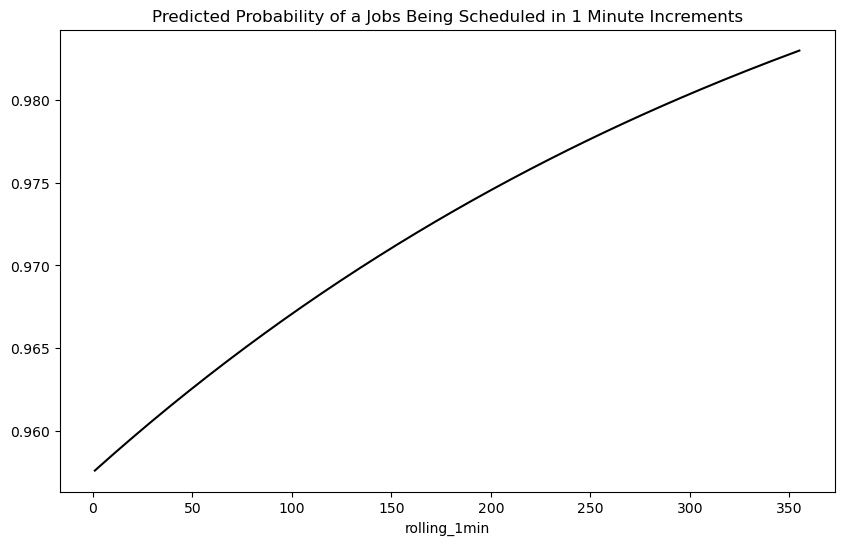

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

fit_df = pd.DataFrame({
    'rolling_1min': np.linspace(start=all_jobs_and_logs['rolling_1min'].min(),
                          stop=all_jobs_and_logs['rolling_1min'].quantile(0.99),
                          num=150)
})

fit_df['fit'] = jobs_complete_1min.predict(fit_df)

fit_df.plot(x='rolling_1min',
           y='fit',
           legend=False,
           ax=ax,  # Pass the axis object to the plot
           color='black',
           title='Predicted Probability of a Jobs Being Scheduled in 1 Minute Increments')

plt.show() 

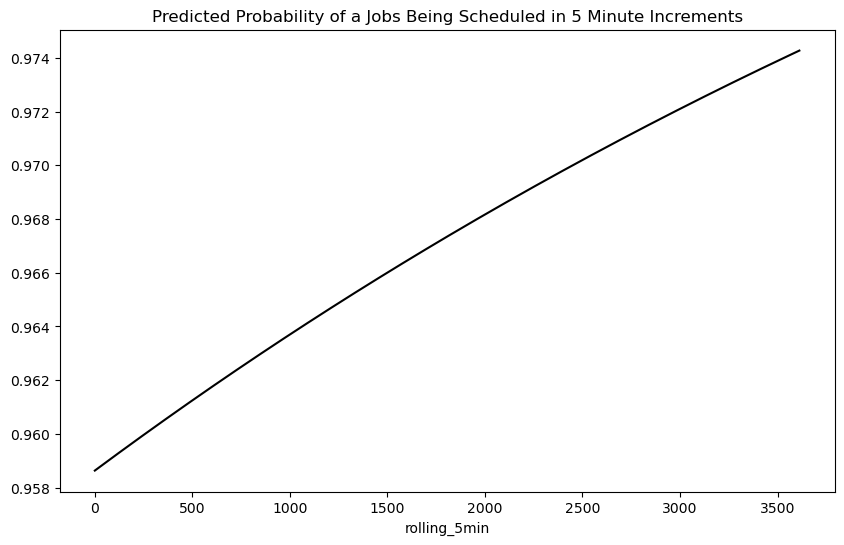

In [71]:
fig, ax = plt.subplots(figsize=(10, 6))

fit_df = pd.DataFrame({
    'rolling_5min': np.linspace(start=all_jobs_and_logs['rolling_5min'].min(),
                          stop=all_jobs_and_logs['rolling_5min'].max(),
                          num=150)
})

fit_df['fit'] = jobs_complete_5min.predict(fit_df)

fit_df.plot(x='rolling_5min',
           y='fit',
           legend=False,
           ax=ax,  # Pass the axis object to the plot
           color='black',
           title='Predicted Probability of a Jobs Being Scheduled in 5 Minute Increments')

plt.show() 

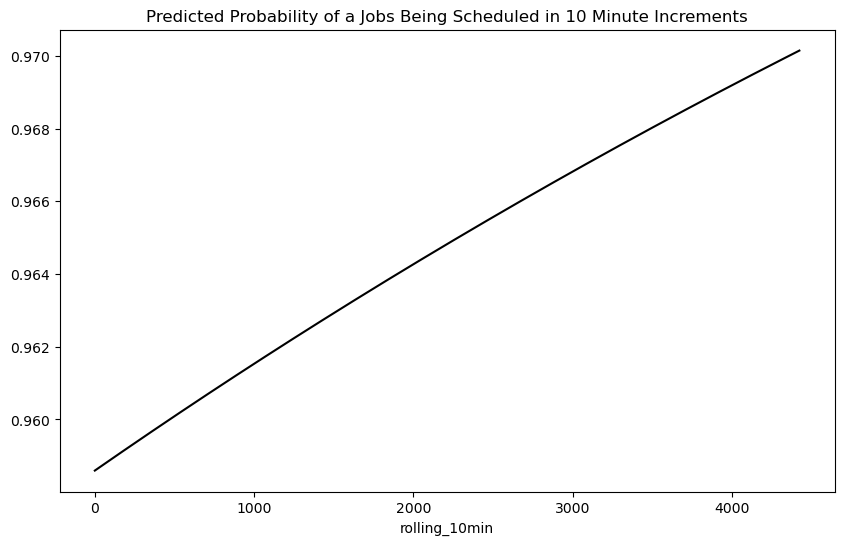

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))

fit_df = pd.DataFrame({
    'rolling_10min': np.linspace(start=all_jobs_and_logs['rolling_10min'].min(),
                          stop=all_jobs_and_logs['rolling_10min'].max(),
                          num=150)
})

fit_df['fit'] = jobs_complete_10min.predict(fit_df)

fit_df.plot(x='rolling_10min',
           y='fit',
           legend=False,
           ax=ax,  # Pass the axis object to the plot
           color='black',
           title='Predicted Probability of a Jobs Being Scheduled in 10 Minute Increments')

plt.show() 

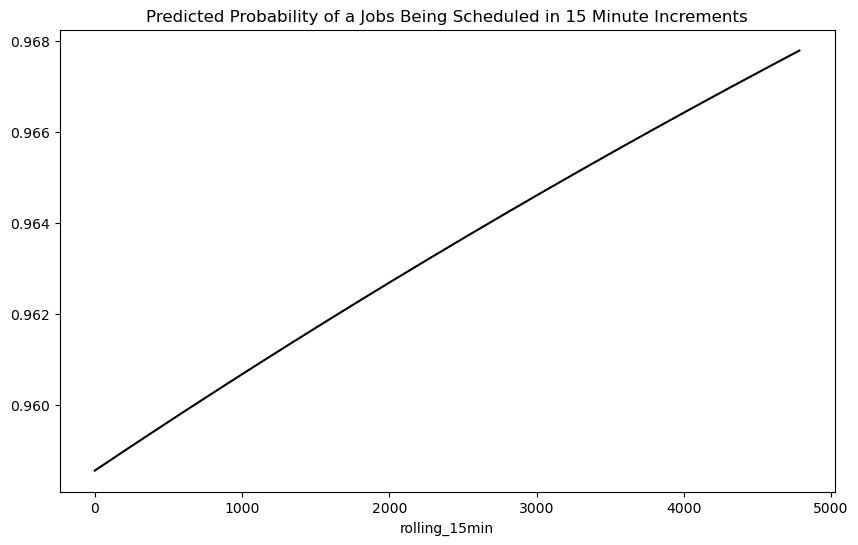

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))

fit_df = pd.DataFrame({
    'rolling_15min': np.linspace(start=all_jobs_and_logs['rolling_15min'].min(),
                          stop=all_jobs_and_logs['rolling_15min'].max(),
                          num=150)
})

fit_df['fit'] = jobs_complete_15min.predict(fit_df)

fit_df.plot(x='rolling_15min',
           y='fit',
           legend=False,
           ax=ax,  # Pass the axis object to the plot
           color='black',
           title='Predicted Probability of a Jobs Being Scheduled in 15 Minute Increments')

plt.show() 

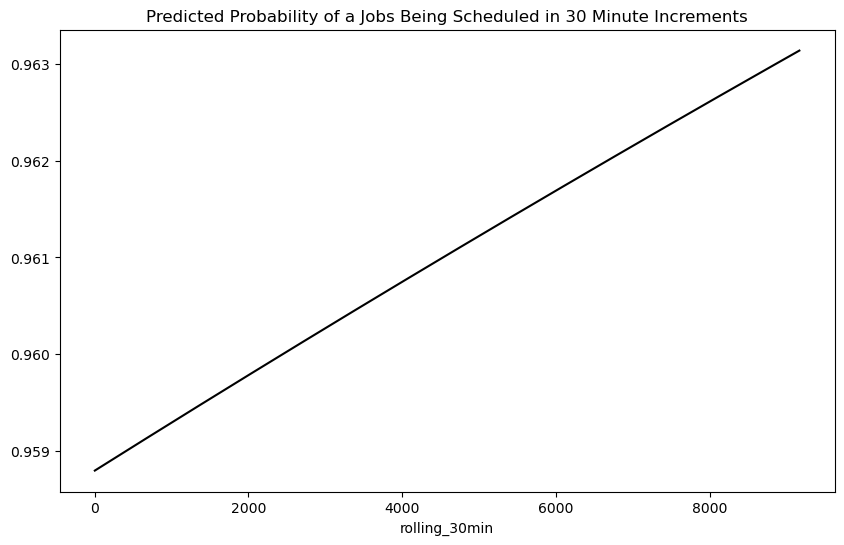

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))

fit_df = pd.DataFrame({
    'rolling_30min': np.linspace(start=all_jobs_and_logs['rolling_30min'].min(),
                          stop=all_jobs_and_logs['rolling_30min'].max(),
                          num=150)
})

fit_df['fit'] = jobs_complete_30min.predict(fit_df)

fit_df.plot(x='rolling_30min',
           y='fit',
           legend=False,
           ax=ax,  # Pass the axis object to the plot
           color='black',
           title='Predicted Probability of a Jobs Being Scheduled in 30 Minute Increments')

plt.show() 

## To conclude... 

The data shows that the scheduler works **more reliably when a larger number of jobs are being processed.** When fewer jobs are scheduled, the scheduler is more likely to become unresponsive or fail to schedule jobs correctly.

ACCRE staff originally believed that the scheduler problems were caused by handling large bursts of completed jobs, especially affecting automated job submissions like those from the Open Science Grid. _However_, our findings do not support this idea. Instead, the results show the opposite: **scheduler issues are more common when job volume is low, not when it is high.**